In [3]:
# load model
import numpy as np
import matplotlib.pyplot as plt
import cobra
import pandas as pd

# model originally from:
# Caspeta L, Shoaie S, Agren R, et al (2012) Genome-scale metabolic reconstructions of Pichia stipitis and Pichia pastoris and in silico evaluation of their potentials. BMC Syst Biol 6:24. doi: 10.1186/1752-0509-6-24.

# model with heterologous protein production was used as starting point for our simulation:
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.

# it is common for these models to give some warnings when uploaded for the first time, so in order to avoid them, it is just required to rewrite the model as follows

#pheast = cobra.io.read_sbml_model("./data/ihGlycopastoris.xml")
#cobra.io.write_sbml_model(pheast,"./data/ihGlycopastoris_rewritten.xml")

pheast = cobra.io.read_sbml_model("./data/ihGlycopastoris_rewritten.xml")

In [2]:
# There are already some predefined compartments in the model, that are required to specify new species: 
pheast.compartments

{'C_c': 'cytosol',
 'C_e': 'extracellular',
 'C_m': 'mitochondrion',
 'C_p': 'peroxisome',
 'C_v': 'vacuole',
 'C_g': 'golgi',
 'C_r': 'ER'}

In [3]:
# In the original model the production of FAB protein was included, but we want to remove its reactions
# those will be include protein transport and protein production (dna, rna, amino acid sequence and protein)
pheast.reactions.query("FAB", "name")

[<Reaction r1338 at 0x1593b6b6b80>,
 <Reaction r1337 at 0x1593b6f50a0>,
 <Reaction r1100 at 0x1593b6fe160>,
 <Reaction r1101 at 0x1593b6ea2b0>,
 <Reaction r1102 at 0x1593b709f70>,
 <Reaction r1103 at 0x1593b6f53a0>]

In [4]:
# we also remove the metabolites related to FAB, which will be those related to dna, rna and amino acid sequence, as well as the protein in different compartments
pheast.metabolites.query("FAB", "name")

[<Metabolite m1360 at 0x1593af53ee0>,
 <Metabolite m1361 at 0x1593af53f10>,
 <Metabolite m1362 at 0x1593af53f40>,
 <Metabolite m1363 at 0x1593af53f70>,
 <Metabolite m1364 at 0x1593af53fa0>]

In [4]:
# first remove the heterologous protein production reactions from the paper

pheast.remove_reactions([pheast.reactions.r1337,
                        pheast.reactions.r1338,
                        pheast.reactions.r1100,
                        pheast.reactions.r1101,
                        pheast.reactions.r1102,
                        pheast.reactions.r1103])

# and all the species related to the protein (dna, rna, aa and the protein on different compartments)

pheast.remove_metabolites([pheast.metabolites.m1360,
                          pheast.metabolites.m1361,
                          pheast.metabolites.m1362,
                          pheast.metabolites.m1363,
                          pheast.metabolites.m1364])

In [5]:
# run the model/optimizes for cell growth
# the usual approach for these models is to optimize cell growth/biomass production, which is also done here (reaction r1339 in this model)
# one can always choose other reactions to be optimized, as will be seen later on

pheast.summary()

# optimize() and summary() methods run the same process, but as the name indicates,
# summary outputs some information for uptake and secretion besides the optimization result, offered by optimize() method

Metabolite,Reaction,Flux,C-Number,C-Flux
m2,r1145,1,0,0.00%
m1231,r1159,0.4626,0,0.00%
m1232,r1160,0.7967,0,0.00%
m1224,r1164,0.03312,0,0.00%
m1233,r1169,0.002458,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.08024,0,0.00%
m1244,r1137,-1.597,0,0.00%
m30,r1150,-3.43,0,0.00%


In [6]:
# one metabolite is uptaken with a rate of 1 mmol gDW^-1 h^-1 (classic GSM models units)
pheast.metabolites.m2

Metabolite identifier,m2
Name,alpha-D-Glucose_C6H12O6
Memory address,0x01ebeeb99580
Formula,
Compartment,C_e
In 3 reaction(s),"r552, r764, r1145"


In [7]:
# there is one secretion reaction (r764), insertion of glucose into the cytosol by using ATP (r552) 
# the glucose uptake reaction (r1145) is where the uptake constraints are defined
# it is seen that glucose is limited to an uptake of a rate of 1 mmol gDW^-1 h^-1 (classic GSM models units)
pheast.reactions.r1145

Reaction identifier,r1145
Name,Uptake of alpha-D-Glucose
Memory address,0x01ebef10d760
Stoichiometry,--> m2 --> alpha-D-Glucose_C6H12O6
GPR,
Lower bound,0.0
Upper bound,1.0


In [8]:
# first, we wanted to see how K. phaffii grew on methanol (as a natural methylotroph) --> look for methanol reactions
pheast.reactions.query("methanol", "name")

[<Reaction r1158 at 0x1ebef10dc70>]

In [9]:
# this is methanol uptake
pheast.reactions.r1158

Reaction identifier,r1158
Name,uptake of methanol
Memory address,0x01ebef10dc70
Stoichiometry,--> m1219 --> Methanol_CH4O
GPR,
Lower bound,0.0
Upper bound,0.0


In [10]:
# One can also query for upper-case methanol and get all reactions for methanol until the start of the MUT pathway
pheast.reactions.query("Methanol", "name")

[<Reaction r91 at 0x1ebee2de100>,
 <Reaction r1310 at 0x1ebef085850>,
 <Reaction r1382 at 0x1ebef0eddc0>]

In [11]:
# this is after the uptake, the methanol is found on the cytoplasm (m1215 is CH3OH found in the cytoplasm)
pheast.reactions.r1382

Reaction identifier,r1382
Name,Methanol permease
Memory address,0x01ebef0eddc0
Stoichiometry,m1219 --> m1215 Methanol_CH4O --> Methanol_CH4O
GPR,
Lower bound,0.0
Upper bound,1000.0


In [12]:
# from the cytoplas is transported to the peroxisoms
pheast.reactions.r1310

Reaction identifier,r1310
Name,Methanol peroxisomal transport
Memory address,0x01ebef085850
Stoichiometry,m1215 --> m956 Methanol_CH4O --> Methanol_CH4O
GPR,
Lower bound,0.0
Upper bound,1000.0


In [13]:
# where the MUT pathway will start
pheast.reactions.r91

Reaction identifier,r91
Name,Methanol:oxygen oxidereductase
Memory address,0x01ebee2de100
Stoichiometry,m711 + m956 --> m713 + m957 Oxygen_O2 + Methanol_CH4O --> H2O2_H2O2 + Formaldehyde_CH2O
GPR,PAS_chr4_0821 or PAS_chr4_0152
Lower bound,0.0
Upper bound,1000.0


In [14]:
# right now the carbon source is glucose --> this is changed to methanol (Methanol_CH4O) instead
pheast.reactions.r1145.bounds = 0, 0  # we force to not upatke any glucose 
pheast.reactions.r1158.bounds = 0, 1  # methanol at 1 mmol gDW^-1 h^-1

In [15]:
# now it grows on methanol (slower than in glucose)
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1219,r1158,1,0,0.00%
m1231,r1159,0.06599,0,0.00%
m1232,r1160,1.258,0,0.00%
m1224,r1164,0.004724,0,0.00%
m1233,r1169,0.0003506,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.01145,0,0.00%
m1244,r1137,-0.372,0,0.00%
m30,r1150,-1.643,0,0.00%


In [16]:
# no methane yet in the model
pheast.metabolites.query("methane", "name")

[]

Next steps are for the introduction of new metabolties and reactions to the model to allow methane uptake and simulate our system:

In [17]:
# we add methane on the extracellular compartment

e_methane = cobra.Metabolite(
    'e_methane',
    formula='CH4',
    name='extracellular_methane',
    compartment='C_e')

pheast.add_metabolites([e_methane])

### Introduction of methanol toxicity data into our model from experimental work

As part of our project, we were recommended to develop some experiments ourselves to get information about our system and provide quality data into the model. It is for that reason that we developed a methanol kill curve into our K. phaffii strain to find out the ability of our strain to metabolize methane without killing it. (We mainly do that as we want our cell to optimize the protein expression.)

In [ ]:
# After developing a methanol kill curve experiment using the WT strain, analyzing the graphs provided by the Biolector,
# we found that K. phaffii could grow on fine conditions until a percentage of around 7% CH3OH concentration in a volume of 
# 1 mL. Below, we will define all the process followed from this data:

# Assumptions done:
# - We assumed when end of exponential phase was reached, it meant all the CH3OH had been uptaken by the cells, which is a 
# very reasonable assumption.
# - We assumed the value just before the end of exponential phase to be our dry weigth during the experiment
# - Lastly, and due to time constraints, for the relation between LSU (Light Scattering Units) and cell dry weight
# we took the calibration from the Biolector manual, that is for E. coli (https://www.m2p-labs.com/applications/notes/)
# for reference this relations is y = 0.015x - 0.055; being "y" the cell dry weight in g/L and x the LSU

# And the data obtained from the Biolector is:
# - 7% CH3OH concentration in 1mL is where the WT K. phaffii starts struggling with methanol toxicity --> initial concentration
# was 70 muL
# - The exponential phase ends at around 12h
# - The cell concentration at that point is 8 LSU --> y = 0.015 * 8 - 0.055 --> concentration is 0.065 g/L

# from this information we needed to get an approximation for the constraint of methanol uptake:
# Considering the density of methanol of 792 kg/m3 and molar mass of 32.04 g/mol, our 70 muL become 0.173 mmoL CH3OH
# Also a cell concentration of 0.065 g/L in 1mL becomes 6.5e-5 gDW.
# As we have concentration of CH3OH, concentration of cells uptaking it and the total time, we can make an approximation
# of the methane uptake as 0.173/(6.5e-5 *12) = 221.84 mmoL/gDW/h

# Although this seemed a very high value to us, and of course there are some assumptions that should be improved in future 
# steps, one must consider that K. phaffii is a natural methylotroph and therefore does make complete sense that methanol 
# uptake is very high for it and that our bottleneck is still the methane upatke done by pMMO

# A similar process as this to obtain constraints on methane uptake will be done later based on literature

In [18]:
# make reactions
# from literature (Lawton, T. J., & Rosenzweig, A. C. (2016). Methane-oxidizing enzymes: an upstream problem in biological gas-to-liquids conversion. Journal of the American Chemical Society, 138(30), 9327-9340.)
# it was found that the methane uptake for M. capsulatus pMMO is between 2.46 mmol/gDW h^-1 and 9 mmol/gDW h^-1, depending on the copper concentration
# we use 10 mmol/gDW/h for now as an approximation
uptake_methane = cobra.Reaction(
            'r_uptake_methane',
            name = 'Methane Uptake from Environment',
            lower_bound = 0,
            upper_bound = 10.0 
        )

methane_oxidation = cobra.Reaction(
            'r_methane_oxidation',
            name = 'Methane Oxidation',
            lower_bound = 0, # meaning irreversibility
            upper_bound = 221.84 # we introduce the constraint obtained from our experiment
    )

# add involved metabolites and stoichiometry

uptake_methane.add_metabolites(
    {
        pheast.metabolites.e_methane: 1.0
    }
)

# pMMO reaction without redox coenzyme (in literature mostly ubiquinol is mentioned but neither there is
# cytosolic ubiquinol in this model (only in mitochondria), nor does the literature agree on what its role may be exactly)
# Lieven, C., Petersen, L. A., Jørgensen, S. B., Gernaey, K. V., Herrgard, M. J., & Sonnenschein, N. (2018). A genome-scale metabolic model for Methylococcus capsulatus 
# (Bath) suggests reduced efficiency electron transfer to the particulate methane monooxygenase. Frontiers in microbiology, 9, 2947.

methane_oxidation.add_metabolites(
    {
        pheast.metabolites.e_methane: -1.0,
        pheast.metabolites.m1232: -1.0,
        pheast.metabolites.m1215: 1.0,
        pheast.metabolites.m139: 1.0,
    }
)

# add gene dependency for pMMO reaction

methane_oxidation.gene_reaction_rule = '( pMMO_A and pMMO_B and pMMO_C )'

# add reactions to pheast

pheast.add_reactions([uptake_methane, 
                      methane_oxidation])

In [19]:
# set methanol uptake to 0 and try if it grows on methane (as upper bound was set to 1)
pheast.reactions.r1158.bounds = 0, 0

In [20]:
# when methane oxidation reaction thanks to pMMO is included, K. phaffii is perfectly able to grow on methane
# but in comparison this growth is slower than methanol and glucose (as if we gave it 1 mmol/gDW/h instead of 10 growth would
# be 0.0057 mmol/gDW/H)
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1231,r1159,0.3299,0,0.00%
m1232,r1160,21.1,0,0.00%
m1224,r1164,0.02362,0,0.00%
m1233,r1169,0.001753,0,0.00%
e_methane,r_uptake_methane,10,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.05723,0,0.00%
m1244,r1137,-6.86,0,0.00%
m30,r1150,-27.84,0,0.00%


In [21]:
# we can copy the model to not modify the original one and knock-out any of the genes involved in pMMO, then it won't grow
pheast_knock_out = pheast.copy()
pheast_knock_out.genes.pMMO_C.knock_out()
pheast_knock_out.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


In [22]:
# we will now introduce our heterologous protein: leghemoglobin
# we look at the detoxification pathway as there is a heme group in both catalase and hemoglobin which could
# influence our system in general and the reaction introduced for production of (leg)hemoglobin
pheast.metabolites.query("H2O2","name")

[<Metabolite m118 at 0x1ebeeba2ca0>,
 <Metabolite m139 at 0x1ebeeba2730>,
 <Metabolite m140 at 0x1ebee9f4ee0>,
 <Metabolite m713 at 0x1ebee9631f0>,
 <Metabolite m1179 at 0x1ebeeb82b20>]

In [23]:
# this is the peroxisomal H2O2
pheast.metabolites.m713

Metabolite identifier,m713
Name,H2O2_H2O2
Memory address,0x01ebee9631f0
Formula,
Compartment,C_p
In 16 reaction(s),"r222, r215, r134, r216, r226, r91, r221, r99, r1088, r220, r217, r218, r225, r219, r223, r224"


In [24]:
# this is the catalase reaction, heme is not considered
pheast.reactions.r99

Reaction identifier,r99
Name,hydrogen-peroxide:hydrogen-peroxide oxidoreductase
Memory address,0x01ebee31e160
Stoichiometry,2.0 m713 --> 2.0 m65 2.0 H2O2_H2O2 --> 2.0 H2O_H2O
GPR,PAS_chr2-2_0131
Lower bound,0.0
Upper bound,1000.0


In [25]:
# we find there is a heme metabolite
pheast.metabolites.query("Heme","name")

[<Metabolite m1051 at 0x1ebeeb8b340>,
 <Metabolite m1059 at 0x1ebeeb8b1f0>,
 <Metabolite m1060 at 0x1ebeeb8b190>]

In [26]:
# it is siroheme
pheast.metabolites.m1060

Metabolite identifier,m1060
Name,Heme A_C49H56FeN4O6
Memory address,0x01ebeeb8b190
Formula,
Compartment,C_m
In 1 reaction(s),r487


In [27]:
# only involved in this reaction; it is also specifically a species of heme different from the one in catalse
# and hemoglobin, so we should not take this one
pheast.reactions.r487

Reaction identifier,r487
Name,Transferase
Memory address,0x01ebeedc2df0
Stoichiometry,m1059 --> m1060 Heme O_C49H58FeN4O5 --> Heme A_C49H56FeN4O6
GPR,PAS_chr4_0449
Lower bound,0.0
Upper bound,1000.0


In [28]:
# there are also a bunch of porypherin metabolites which are similar to the hemoglobin
pheast.metabolites.query("porphyrin","name")

#    A. Díaz, P.C. Loewen, I. Fita, X. Carpena
#    Thirty years of heme catalases structural biology
#    Arch. Biochem. Biophys., 525 (2012), pp. 102-110

# According to the source above C34-heme b is the most abundant, so we could go for that (there are some C34
# poryphyrins) and introduce it in the catalase and later hemoglobin reaction but none are in the peroxisome

[<Metabolite m1045 at 0x1ebeeb8b460>,
 <Metabolite m1046 at 0x1ebeeb8b490>,
 <Metabolite m1047 at 0x1ebeeb8b430>,
 <Metabolite m1048 at 0x1ebeeb8b3d0>,
 <Metabolite m1049 at 0x1ebeeb8b400>,
 <Metabolite m1055 at 0x1ebeeb8b2e0>,
 <Metabolite m1056 at 0x1ebeeb8b280>,
 <Metabolite m1185 at 0x1ebeeb82a00>]

In [29]:
# now we will introduce the heterologous proteins, pMMO and leghemoglobin, with reactions for dna replication,
# transcription and translation
# as the sequences are long, we calculate the stoichiometry with a script which is on the github repo and imported here
# based on the logic behind introduction of heterologous protein production in the paper:
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.
# for that we define the following function

import stoichiometry_gsm

def add_protein_reaction(model, reaction, lb, ub, seq, seq_type, protein_name):
    
    stoichiometry = stoichiometry_gsm.get_stoichiometry(seq, seq_type, protein_name)
    
    reaction = cobra.Reaction(
                reaction,
                name = reaction,
                lower_bound = lb,
                upper_bound = ub
        )
    
    for molecule in stoichiometry:
        reaction.add_metabolites(
            {
                getattr(model.metabolites, molecule): stoichiometry[molecule] 
            }
        )
    
    model.add_reactions([reaction])

In [30]:
# and get the sequences for our two recombinant proteins, pMMO and leghemoglobin. defined before in another file
from sequences import *

In [31]:
# add the metabolites to be produced by these reactions

pMMO_DNA = cobra.Metabolite(
    'pMMO_DNA',
    name='pMMO_DNA',
    compartment='C_c')

pMMO_RNA = cobra.Metabolite(
    'pMMO_RNA',
    name='pMMO_RNA',
    compartment='C_c')

pMMO_AA = cobra.Metabolite(
    'pMMO_AA',
    name='pMMO_AA',
    compartment='C_c')

hemo_DNA = cobra.Metabolite(
    'hemo_DNA',
    name='Hemo_DNA',
    compartment='C_c')

hemo_RNA = cobra.Metabolite(
    'hemo_RNA',
    name='Hemo_RNA',
    compartment='C_c')

hemo_AA = cobra.Metabolite(
    'hemo_AA',
    name='Leghemoglobin',
    compartment='C_c')


pheast.add_metabolites([pMMO_DNA,
                       pMMO_RNA,
                       pMMO_AA,
                       hemo_DNA,
                       hemo_RNA,
                       hemo_AA])

In [32]:
# make new reactions
# IMPORTANT! make sure the protein name is the same as you defined the metabolites, otherwise it will fail
add_protein_reaction(pheast, 'pMMO_DNA_reaction', 0, 1000, pMMO_dna_seq, 'dna', 'pMMO')
add_protein_reaction(pheast, 'pMMO_RNA_reaction', 0, 1000, pMMO_rna_seq, 'rna', 'pMMO')
add_protein_reaction(pheast, 'pMMO_AA_reaction', 0, 1000, pMMO_aa_seq, 'aa', 'pMMO')
add_protein_reaction(pheast, 'hemo_DNA_reaction', 0, 1000, hemo_dna_seq, 'dna', 'hemo')
add_protein_reaction(pheast, 'hemo_RNA_reaction', 0, 1000, hemo_rna_seq, 'rna', 'hemo')
add_protein_reaction(pheast, 'hemo_AA_reaction', 0, 1000, hemo_aa_seq, 'aa', 'hemo')

In [33]:
# also add transport to extracellular and boundary proteins as well as "Biosynthesis" reactions
# this was all done in the reference provided

pMMO_c = cobra.Metabolite(
    'pMMO_c',
    formula='',
    name='pMMO_cytosolic',
    compartment='C_c')

pMMO_e = cobra.Metabolite(
    'pMMO_e',
    formula='',
    name='pMMO_extracellular',
    compartment='C_e')

hemo_c = cobra.Metabolite(
    'hemo_c',
    formula='',
    name='hemo_cytosolic',
    compartment='C_c')

hemo_e = cobra.Metabolite(
    'hemo_e',
    formula='',
    name='hemo_extracellular',
    compartment='C_e')

pheast.add_metabolites([pMMO_c,
                        pMMO_e,
                        hemo_c,
                        hemo_e])

# As our pMMO will be introduced after a constitutive promoter (GAP), we force the pMMO biosynthesis to the level taken as a basis 
# to ensure proper methane uptake values, see below:
# there we simulate assuming pMMO could be 5, 10 and 20% of protein as an educational process

# from these references: Geisberg, Joseph V., et al. "Global analysis of mRNA isoform half-lives reveals stabilizing and 
# destabilizing elements in yeast." Cell 156.4 (2014): 812-824.
# and Christiano R, Nagaraj N, Fröhlich F, Walther TC. Global proteome turnover analyses of the Yeasts S. cerevisiae and 
# S. pombe. Cell Rep. 2014 Dec 11 9(5):1959-65. doi: 10.1016/j.celrep.2014.10.065. 
# we used 5 hours as a good approximation for protein, that means that to keep the steady-state required for GSM, we need to
# keep a pMMO production to the same rate as it degrades, which is dProtein(t)/dt = -lambda * Protein(t)

# we know that exponential decay, half-life t = ln(2) / lambda; therefore lambda = ln(2) / 5 for us
# as our units are g/gDW/h and we assumed 50 % of the dry weight to be protein (https://bionumbers.hms.harvard.edu/bionumber.aspx?&id=102328)
# our formula to find this production rate is lambda * Protein(steady-state) = ln(2) / 5 * 50% * x%, where x is the percentage
# we decide to use for our case, therefore

#  5% --> ln(2)/5 * 0.025 = 0.0035
# 10% --> ln(2)/5 * 0.05 = 0.0069
# 20% --> ln(2)/5 * 0.1 = 0.0138

# we will use 10% for now 

pMMO_Biosynthesis = cobra.Reaction(
            'pMMO_Biosynthesis',
            name = 'pMMO Biosynthesis',
            lower_bound = 0.0069,
            upper_bound = 0.0069
)

hemo_Biosynthesis = cobra.Reaction(
            'hemo_Biosynthesis',
            name = 'LeghemoglobinBiosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

extrac_pMMO = cobra.Reaction(
            'c_pMMO_e',
            name = 'extracellular transport pMMO',
            lower_bound = 0,
            upper_bound = 1000.0
)

extrac_Hemo = cobra.Reaction(
            'c_Hemo_e',
            name = 'extracellular transport Leghemoglobin',
            lower_bound = 0,
            upper_bound = 1000.0
)

EX_hemo = cobra.Reaction(
            'EX_hemo',
            name = 'hemoglobin exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

EX_pMMO = cobra.Reaction(
            'EX_pMMO',
            name = 'pMMO exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)



hemo_Biosynthesis.add_metabolites(
    {
        pheast.metabolites.hemo_DNA: -2.8e-05,
        
        pheast.metabolites.hemo_RNA: -0.0029,
        
        pheast.metabolites.hemo_AA: -0.997,

        pheast.metabolites.hemo_c: 1.0,
    }
)

pMMO_Biosynthesis.add_metabolites(
    {       
        pheast.metabolites.pMMO_DNA: -2.8e-05,
        
        pheast.metabolites.pMMO_RNA: -0.0029,
        
        pheast.metabolites.pMMO_AA: -0.997,

        pheast.metabolites.pMMO_c: 1.0,
    }
)


extrac_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_c: -1.0,   
        
        pheast.metabolites.pMMO_e: 1.0
    }
)

extrac_Hemo.add_metabolites(
    {
        pheast.metabolites.hemo_c: -1.0,   
        
        pheast.metabolites.hemo_e: 1.0
    }
)

EX_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_e: -1.0
    }
)

EX_hemo.add_metabolites(
    {
        pheast.metabolites.hemo_e: -1.0
    }
)

pheast.add_reactions([extrac_pMMO,
                    extrac_Hemo,
                    pMMO_Biosynthesis,
                    hemo_Biosynthesis,
                    EX_hemo,
                    EX_pMMO])

In [34]:
# One option is to once we have the protein production reaction, optimize that reaction
pheast_final = pheast.copy()
pheast_final.objective = pheast_final.problem.Objective(pheast_final.reactions.hemo_Biosynthesis.flux_expression)
pheast_final.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1231,r1159,0.8734,0,0.00%
m1232,r1160,20.96,0,0.00%
m1224,r1164,0.000772,0,0.00%
m1233,r1169,0.006426,0,0.00%
e_methane,r_uptake_methane,10,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
hemo_e,EX_hemo,-0.08233,0,0.00%
pMMO_e,EX_pMMO,-0.0069,0,0.00%
m1244,r1137,-6.515,0,0.00%
m30,r1150,-27.18,0,0.00%


In [35]:
cobra.summary.MetaboliteSummary(metabolite= pheast_final.metabolites.hemo_c, model=pheast_final)

Percent,Flux,Reaction,Definition
100.00%,0.08233,hemo_Biosynthesis,0.997 hemo_AA + 2.8e-05 hemo_DNA + 0.0029 hemo_RNA --> hemo_c
Percent,Flux,Reaction,Definition
100.00%,-0.08233,c_Hemo_e,hemo_c --> hemo_e


In [36]:
cobra.summary.reaction_summary.ReactionSummary(reaction = pheast_final.reactions.hemo_Biosynthesis, model = pheast_final)

In [37]:
# and we see indeed our pMMO production is fixed at 0.0069 mmol/gDW/h
cobra.summary.reaction_summary.ReactionSummary(reaction = pheast_final.reactions.pMMO_Biosynthesis, model = pheast_final)

In [38]:
# However the procedure used in original paper: 
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.
# the procedure is first optimize for the growth, and then use this value as constrain in the next optimization of protein production
pheast_growth_constraint = pheast.copy()
pheast_growth_constraint.objective = pheast_growth_constraint.problem.Objective(pheast_growth_constraint.reactions.r1339.flux_expression)
pheast_growth_constraint.reactions.r1339.bounds = pheast_growth_constraint.optimize().objective_value, pheast_growth_constraint.optimize().objective_value

In [39]:
# and once constrained, we optimize the protein production reaction 
# but with this approach our model is unable to keep the optimal growth and produce recombinant proteins at the same time
# (which makes sense to us)
pheast_growth_constraint.objective = pheast_growth_constraint.problem.Objective(pheast_growth_constraint.reactions.hemo_Biosynthesis.flux_expression)
pheast_growth_constraint.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1231,r1159,0.3723,0,0.00%
m1232,r1160,21.09,0,0.00%
m1224,r1164,0.02178,0,0.00%
m1233,r1169,0.003508,0,0.00%
e_methane,r_uptake_methane,10,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
pMMO_e,EX_pMMO,-0.0069,0,0.00%
m1226,r1133,-0.05263,0,0.00%
m1244,r1137,-6.836,0,0.00%
m30,r1150,-27.8,0,0.00%


In [40]:
cobra.summary.MetaboliteSummary(metabolite= pheast_growth_constraint.metabolites.hemo_c, model=pheast_growth_constraint)

Percent,Flux,Reaction,Definition
Percent,Flux,Reaction,Definition


In [41]:
# this command fails as there is no flux through this reaction
cobra.summary.reaction_summary.ReactionSummary(reaction = pheast_growth_constraint.reactions.hemo_Biosynthesis, model = pheast_growth_constraint)

KeyError: 'hemo_Biosynthesis'

## Now we check for knockouts and study how they behave

In [42]:
# as recommended on cobrapy documentation the following command will be run to develop all model single deletions
# https://cobrapy.readthedocs.io/en/latest/deletions.html
from cobra.flux_analysis import (single_gene_deletion, single_reaction_deletion, double_gene_deletion,double_reaction_deletion)

In [43]:
# first of all, we want to predict the behavior of our system when methanol oxidation pathway is knocked-out and compare it 
# with our experimental results --> we need to first recover which specific genes must be knocked-out
# remember that running the command: "pheast.reactions.query("Methanol", "name")", we get all reactions
pheast.reactions.r91 # this is the one in the MUT pathway for methanol oxidation

Reaction identifier,r91
Name,Methanol:oxygen oxidereductase
Memory address,0x01ebee2de100
Stoichiometry,m711 + m956 --> m713 + m957 Oxygen_O2 + Methanol_CH4O --> H2O2_H2O2 + Formaldehyde_CH2O
GPR,PAS_chr4_0821 or PAS_chr4_0152
Lower bound,0.0
Upper bound,1000.0


In [44]:
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1231,r1159,0.3723,0,0.00%
m1232,r1160,21.09,0,0.00%
m1224,r1164,0.02178,0,0.00%
m1233,r1169,0.003508,0,0.00%
e_methane,r_uptake_methane,10,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
pMMO_e,EX_pMMO,-0.0069,0,0.00%
m1226,r1133,-0.05263,0,0.00%
m1244,r1137,-6.836,0,0.00%
m30,r1150,-27.8,0,0.00%


In [45]:
# we knock-out the two genes involved in methanol oxidation, which are the Ordered Locus Names of AOX1 
# (https://www.uniprot.org/uniprot/P04842) and AOX2 (https://www.uniprot.org/uniprot/C4R702)
pheast_oxidation_knockout = pheast.copy()
pheast_oxidation_knockout.genes.PAS_chr4_0821.knock_out()
pheast_oxidation_knockout.genes.PAS_chr4_0152.knock_out()
pheast_oxidation_knockout.summary()

Infeasible: None (infeasible).

In [32]:
# We also tried to implement an already present functionality in Cobrapy that knocks-out one gene at a time and optimizing
# this is also a very useful funcionality of cobrapy as it allows to check for potential improvements of the system
deletion_results = single_gene_deletion(pheast_final)
pd.set_option("display.max_rows", None, "display.max_columns", None) # just using pandas package for visual reasons

For space reasons we have removed the results from this simulation, but this was not successful as after each single deletion either the model failed or it reached the same optimized value.

## Finding a realistic assumption for methane uptake

In [35]:
# we can try different scenarios of the methane oxidation reaction:

# amount of protein in yeast cell is about 50%
# https://bionumbers.hms.harvard.edu/bionumber.aspx?&id=102328

# AOX expression accounts for 5-30% --> thus we take 3 scenarios in which pMMO makes up (1)5, (2)10 and (3)20% of
# total protein per gram DW
# Couderc, R., & Baratti, J. (1980). Oxidation of methanol by the yeast, Pichia pastoris. Purification and properties of the alcohol oxidase. Agricultural and biological chemistry, 44(10), 2279-2289.
# Vogl, T., & Glieder, A. (2013). Regulation of Pichia pastoris promoters and its consequences for protein production. New biotechnology, 30(4), 385-404.
# expression under GAP in glucose medium can reach even higher ones compared to AOX in methanol :
# Karaoglan, M., Karaoglan, F. E., & Inan, M. (2016). Comparison of ADH3 promoter with commonly used promoters for recombinant protein production in Pichia pastoris. Protein expression and purification, 121, 112-117.
# Waterham, H. R., Digan, M. E., Koutz, P. J., Lair, S. V., & Cregg, J. M. (1997). Isolation of the Pichia pastoris glyceraldehyde-3-phosphate dehydrogenase gene and regulation and use of its promoter. Gene, 186(1), 37-44.
# We leave that question open as there are no good absolute numbers and we cannot simulate switching media which we will do in vitro/vivo.


# as the turnover rate for the pMMO is estimated/measured at about 0.5-2.5, we choose 1 as a conservative parameter
# for our pMMO
# Hakemian, A. S., & Rosenzweig, A. C. (2007). The biochemistry of methane oxidation. Annu. Rev. Biochem., 76, 223-241.

# mass of pMMO is about 300 kDA
# Ross, M. O., & Rosenzweig, A. C. (2017). A tale of two methane monooxygenases. JBIC Journal of Biological Inorganic Chemistry, 22(2-3), 307-319.
# one pMMO has a weight of about 4.981620599999999e-19

# --> in one gDW there will be 
# (1) 0.025g pMMO --> 5.0184472e+16 molecules of pMMO --> 0.29999978778 mmol of CH4 -> CH3OH per gDW/h
# (2) 0.05g pMMO --> 1.0036894e+17 molecules of pMMO --> 0.59999955165 mmol of CH4 -> CH3OH per gDW/h
# (3) 0.1g pMMO --> 2.0073789e+17 molecules of pMMO --> 1.19999916309 mmol of CH4 -> CH3OH per gDW/h

# e.g. pheast.reactions.methane_oxidation.bounds = -1000,0.59999955165

# --> pheast will metabolize as much methane as possible due to constraints of pMMO and methane availability
# --> In a good scenario in which 20% of the total cell protein is pMMO, about 1.2 mmol/gDW/h corresponding to
# about 0.02 g or 0.03 ml of methane per gDW/h (at a temperature of 37 degrees Celsius considering a CH4 density of 0.623 kg/m3) 
# (https://www.engineeringtoolbox.com/methane-density-specific-weight-temperature-pressure-d_2020.html)
# are needed to reach maximal efficiency (limited by pMMO activity)
# thus the process will have a bottleneck at the fermentation technology level

# --> on the other hand if we expect to have at least 5% of the total cell protein to be functional pMMO with the
# given turnover rate as 1, per gDW/h the culture would need 0.00772391 ml of methane to use it optimally

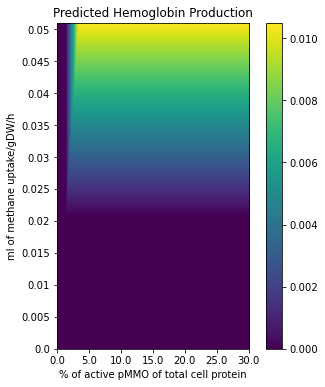

In [258]:
def methane_ml_to_mmol_at_37(ml):
    return(ml*0.623/0.01604)

def pMMO_uptake_capacity(model, precision, max_pMMO_percent):

    # vector for pMMO percentage
    pMMO_percentages = list(np.arange(0,max_pMMO_percent+precision,precision))

    # from best case scenario we can say that 0.03ml is max methane uptake /gDW/h; we set it to 0.05 as we also
    # simulate 30% protein here and it is good to have some margin in any case
    
    methane_concentrations = list(np.arange(0,0.05+0.001,0.0001))


    # results matrix
    plot = np.zeros([len(methane_concentrations),len(pMMO_percentages)])
    
    xticks = []
    yticks = set()
    
    for index1,pMMO in enumerate(pMMO_percentages):
        xticks.append(index1)
        for index2,methane in enumerate(methane_concentrations):
            yticks.add(index2)
            # calculate potential methane consumption
            # 1. convert g of pMMO to molecules to mmol
            # weight of pMMO = 4.981620599999999e-19, 0.5 as 50% protein in cell, 6E+23 avogadro's number,
            # 1000 because of mmol <-> mol, 3600 s <-> h
            mmol = ((pMMO/100)*0.5) / 4.981620599999999e-20 / 6.0221409e+23 * 1000 * 3600

            # set uptake and optimise

            model.reactions.r_uptake_methane.bounds = 0, methane_ml_to_mmol_at_37(methane)
            model.reactions.r_methane_oxidation.bounds = 0, mmol
            result = model.optimize().objective_value
            result = 0 if result < 0 else result # consider negative results as no protein production
            plot[index2,index1] = result

    yticks = list(yticks)
    plt.figure(figsize=(6, 6))
    imgplot = plt.imshow(plot,extent=[0,len(pMMO_percentages),len(methane_concentrations),0])
    plt.colorbar()
    plt.title("Predicted Hemoglobin Production")
    plt.xlabel("% of active pMMO of total cell protein")
    plt.ylabel("ml of methane uptake/gDW/h")
    plt.gca().invert_yaxis()
    label_meth = methane_concentrations
    label_pMMO = pMMO_percentages
    plt.xticks([round(xticks[i],3) for i in range(0,len(xticks),50)], [round(label_pMMO[i],3) for i in range(0,len(label_pMMO),50)])
    plt.yticks([round(yticks[i],3) for i in range(0,len(yticks),50)], [round(label_meth[i],3) for i in range(0,len(label_meth),50)])
    

pMMO_uptake_capacity(pheast_final,0.1,30)

In [46]:
# thus the max yield of hemoglobin at a methane uptake at about 1.8 mmol/gDW/h (0.033 ml) and 30% of total protein 
# being functional pMMO would be (in a scenario knocking out the AOX)

pheast_final.reactions.r_uptake_methane.bounds = 0,1.8
pheast_final.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1231,r1159,0.156,0,0.00%
m1232,r1160,3.774,0,0.00%
m1224,r1164,0.0001348,0,0.00%
m1233,r1169,0.002387,0,0.00%
e_methane,r_uptake_methane,1.8,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
hemo_e,EX_hemo,-0.008917,0,0.00%
pMMO_e,EX_pMMO,-0.0069,0,0.00%
m1244,r1137,-1.177,0,0.00%
m30,r1150,-4.906,0,0.00%


## Optimizing conditions for protein production of our cell-factory

Now, we want to use our new model that simulates our K. phaffii status to analyze the optimal environmental conditions for the maximal protein production. For our systems the case that makes most sense is to focus on oxygen and methane, as this last will be the unique carbon source considered.

In [47]:
# we create a function to see how our protein production is optimize on different environments
def optimal_conditions(model, precision, max_met, max_ox):
    plot = np.zeros([precision, precision])
    methane_vec = np.linspace(0,max_met,precision); oxygen_vec = np.linspace(0,max_ox,precision)
    for count_ox, oxygen in enumerate(oxygen_vec):
        for count_met, met in enumerate(methane_vec):
            # force cell to uptake the oxygen and methane available on each condition simulated
            model.reactions.r1160.bounds = oxygen, oxygen 
            model.reactions.r_uptake_methane.bounds = met, met 
            result = model.optimize().objective_value
            if result < 0: 
                result = 0
            plot[(precision-1 - count_ox), count_met] = result
    label_met = np.round(np.linspace(0, max_met, 6),1)
    label_ox = np.round(np.linspace(max_ox, 0,6),1)
    ticks = np.linspace(0, precision - 1,6)
    imgplot = plt.imshow(plot)
    plt.colorbar()
    #plt.gca().invert_yaxis()
    plt.title("Optimization of protein production on different environment uptake")
    plt.xlabel("Methane uptake")
    plt.ylabel("Oxygen uptake")
    plt.xticks(ticks, label_met)
    plt.yticks(ticks, label_ox)
    plt.grid()
    return plot

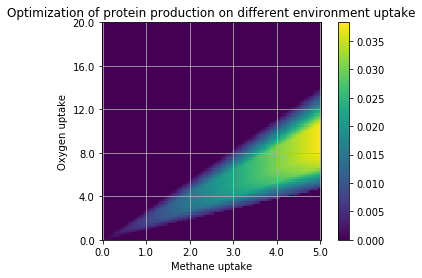

In [14]:
plot = optimal_conditions(pheast_final, precision = 100, max_met = 5, max_ox = 20) # units in mmol/gDW/h

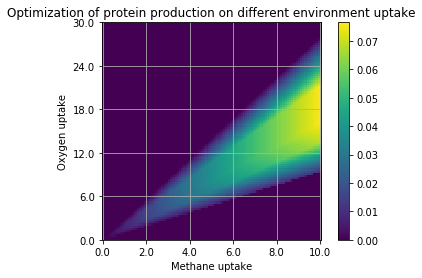

In [15]:
plot = image_plot(pheast_final, precision = 100, max_met = 10, max_ox = 30)

Therefore, we see that there is a correlation between methane and oxygen for the best protein production, in a way that this is closer to approx. 2:1 for oxygen:methane, respectively. But then, of course, the higher are those uptakes following the relation, the better is the protein production following a linear relation.

The reasons we think for this plot shape is that, below the 1:1 relation between oxygen and methane, as we are forcing our model to uptake all the methane, it is unfeasible as for that we need the same amount of oxygen. Otherwise, some methane that we are forcing to get inside the cell, can't because we don't have enough oxygen.

The gradient on protein production when increasing oxygen might be explained because when the relation is exactly 1:1, all oxygen is used for the uptake of methane and then all the protein we are producing comes from the amino acids uptaken from the environment. As soon, as we have more oxygen availbale, the cell is able to produce its own DNA, RNA and amino acids.

(The upper limit on oxygen is also because we are forcing the cell to take all the oxygen. There must be some other reaction besides pMMO that is helping to get that oxygen inside the cell, otherwise we would just get a x=y line and all the rest would be inbfeasible. But the idea is that once these reactions reach their limit for oxygen, the model is infeasible.)

Some explanation we have for the upper gradient is that once we surpass the optimal oxygen value for protein production, this extra oxygen requires some ATP to be metabolized instead of being used for protein production.

It is infeasible for uppeer values of oxygen, for the same reason as for the methane because at some point we can't use all the oxygen available.

We also found some limit on the amount of methane that can be uptaken even though we keep increasing the uptake of both. And actually, after some point the protein production starts to decrease. The reason we thouhgt for it is that there is this upper limit for reactions to go to 1000, then it might be that going up and up for this methane is saturating some of the reactions further down where some reaction is surpassing this 1000 limit.

And right now we don't have any limit on methane uptake until that approx. 1000 because we don't have any toxicity for methanol nor any other product further down that is telling our model that it is not allowed to surpass some value for some given metabolite.

## K. phaffii growth rate simulation in glucose for our Parts Registry

In [48]:
def optimal_conditions_glucose(model, precision, max_gluc, max_ox):
    plot = np.zeros([precision, precision])
    glucose_vec = np.linspace(0,max_gluc,precision); oxygen_vec = np.linspace(0,max_ox,precision)
    for count_ox, oxygen in enumerate(oxygen_vec):
        for count_gluc, gluc in enumerate(glucose_vec):
            # force cell to uptake the oxygen and methane available on each condition simulated
            model.reactions.r1160.bounds = oxygen, oxygen 
            model.reactions.r1145.bounds = gluc, gluc 
            result = model.optimize().objective_value
            if result < 0: 
                result = 0
            plot[(precision-1 - count_ox), count_gluc] = result
    label_gluc = np.round(np.linspace(0, max_gluc, 6),1)
    label_ox = np.round(np.linspace(max_ox, 0,6),1)
    ticks = np.linspace(0, precision - 1,6)
    imgplot = plt.imshow(plot)
    plt.colorbar()
    #plt.gca().invert_yaxis()
    plt.title(r"Optimization of biomass production", fontsize = 20)
    plt.xlabel("Glucose uptake", fontsize = 14)
    plt.ylabel("Oxygen uptake", fontsize = 14)
    plt.xticks(ticks, label_gluc, fontsize = 12)
    plt.yticks(ticks, label_ox, fontsize = 12)
    plt.grid()
    return plot

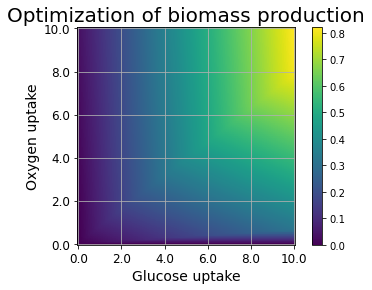

In [296]:
plot = optimal_conditions_glucose(model = pheast, precision = 100, max_gluc = 10, max_ox = 10)